# Defect Detection for YiDianZhiNeng

## Libs import

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *

In [3]:
path = Path("/home/ubuntu/notebooks/data/train")

## Data Load and processing

In [4]:
path.ls()

[PosixPath('/home/ubuntu/notebooks/data/train/OK'),
 PosixPath('/home/ubuntu/notebooks/data/train/NG'),
 PosixPath('/home/ubuntu/notebooks/data/train/models')]

In [5]:
classes = ["OK","NG"]

In [6]:
np.random.seed(42)

In [8]:
tfms = get_transforms()

In [8]:
size = 224

In [9]:
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
                                 ds_tfms=tfms, size=size, num_workers=4).normalize(imagenet_stats)

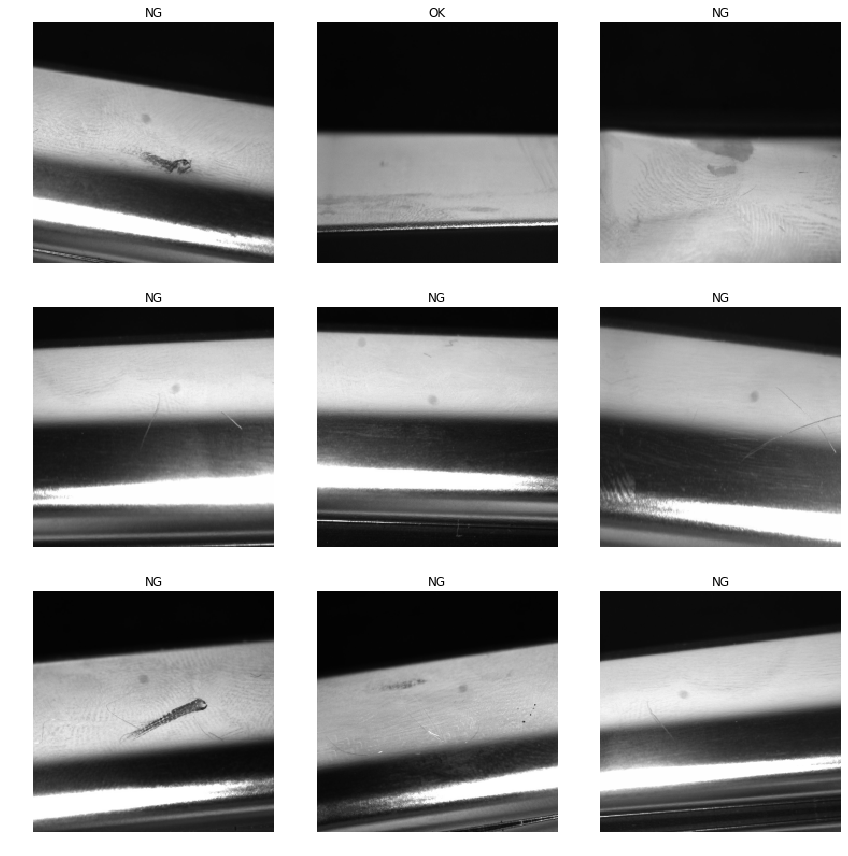

In [10]:
data.show_batch(rows=3)

In [12]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['NG', 'OK'], 2, 94, 23)

## Train a BaseLine Model

In [18]:
learn = create_cnn(data, models.resnet34, metrics=accuracy)

In [14]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


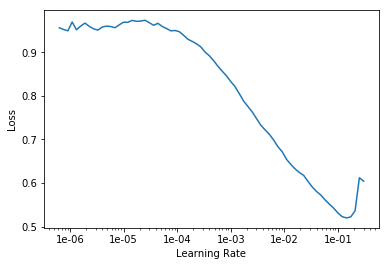

In [15]:
learn.recorder.plot()

In [19]:
learn.fit_one_cycle(5,max_lr=1e-3)

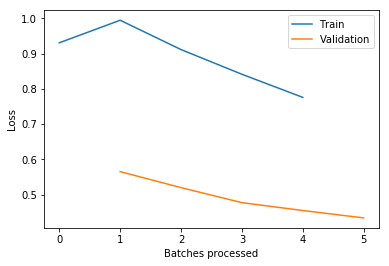

In [20]:
learn.recorder.plot_losses()

In [21]:
learn.save("stage-1-resnet34")

In [22]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


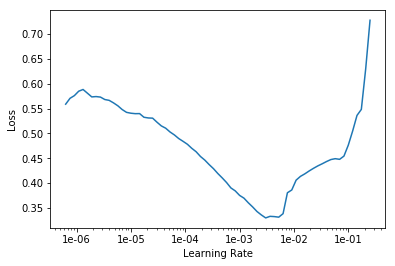

In [23]:
learn.lr_find()
learn.recorder.plot()

In [24]:
learn.fit_one_cycle(5,slice(1e-4, 3e-3/5))

In [25]:
learn.save("stage-2-resnet34")

### Use Larger graphs

In [26]:
size = 512

In [27]:
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
                                 ds_tfms=tfms, size=size, num_workers=4).normalize(imagenet_stats)

In [28]:
learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 512, 512])

In [29]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


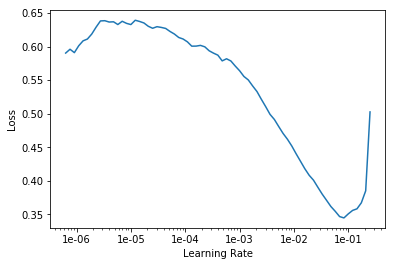

In [30]:
learn.lr_find()
learn.recorder.plot()

In [31]:
learn.fit_one_cycle(5, 1e-2)

In [32]:
learn.unfreeze()

In [33]:
learn.fit_one_cycle(5, slice(1e-5, 1e-2/5))

In [34]:
learn.save("final01")

## Analysis

In [35]:
interp = ClassificationInterpretation.from_learner(learn)

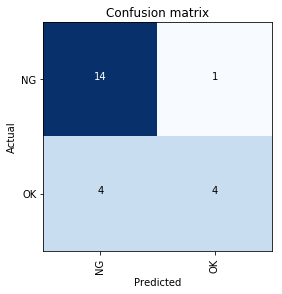

In [36]:
interp.plot_confusion_matrix()

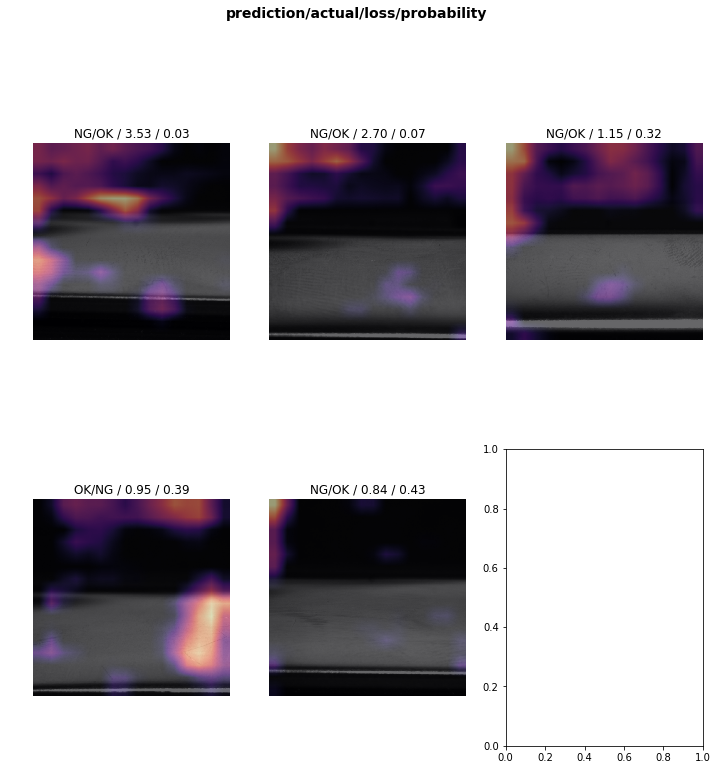

In [38]:
interp.plot_top_losses(5)

In [39]:
interp.most_confused()

[('OK', 'NG', 4), ('NG', 'OK', 1)]

  ## Try another base model      

In [9]:
size = 488
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2, bs=4,
                                 ds_tfms=tfms, size=size, num_workers=4).normalize(imagenet_stats)

In [17]:
learn = create_cnn(data, models.resnet50, metrics=accuracy)

/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/vision/learner.py:105: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


In [52]:
print(learn.summary())

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [1, 64, 256, 256]    9,408      False     
______________________________________________________________________
BatchNorm2d          [1, 64, 256, 256]    128        True      
______________________________________________________________________
ReLU                 [1, 64, 256, 256]    0          False     
______________________________________________________________________
MaxPool2d            [1, 64, 128, 128]    0          False     
______________________________________________________________________
Conv2d               [1, 64, 128, 128]    4,096      False     
______________________________________________________________________
BatchNorm2d          [1, 64, 128, 128]    128        True      
______________________________________________________________________
Conv2d               [1, 64, 128, 128]    36,864     False     
______________________________________________________________

In [12]:
learn.fit_one_cycle(5,max_lr=1e-3)

In [13]:
learn.save("stage-1-resnet50")

In [18]:
learn.load("stage-1-resnet50")

Learner(data=ImageDataBunch;

Train: LabelList (94 items)
x: ImageList
Image (3, 488, 488),Image (3, 488, 488),Image (3, 488, 488),Image (3, 488, 488),Image (3, 488, 488)
y: CategoryList
OK,OK,OK,OK,OK
Path: /home/ubuntu/notebooks/data/train;

Valid: LabelList (23 items)
x: ImageList
Image (3, 488, 488),Image (3, 488, 488),Image (3, 488, 488),Image (3, 488, 488),Image (3, 488, 488)
y: CategoryList
NG,OK,NG,NG,OK
Path: /home/ubuntu/notebooks/data/train;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [19]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


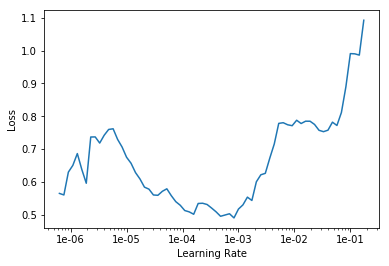

In [15]:
learn.lr_find()
learn.recorder.plot()

In [20]:
learn.fit_one_cycle(5,slice(1e-5,3e-3/10))

In [21]:
learn.save("final02-resnet50-0.91")

In [22]:
interp = ClassificationInterpretation.from_learner(learn)

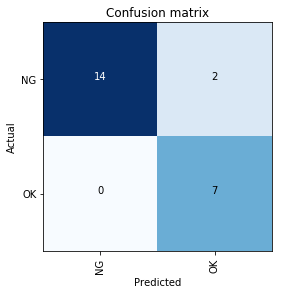

In [23]:
interp.plot_confusion_matrix()

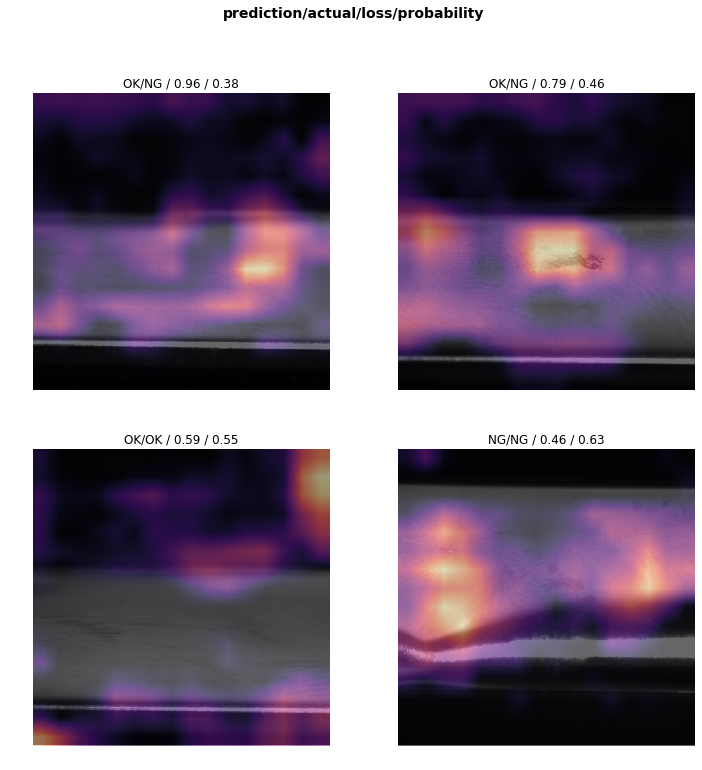

In [24]:
interp.plot_top_losses(4)

## Export

In [25]:
learn.export()

## Test

In [27]:
test_path = Path("/home/ubuntu/notebooks/data/test")

In [28]:
img = open_image(test_path/"39.bmp")

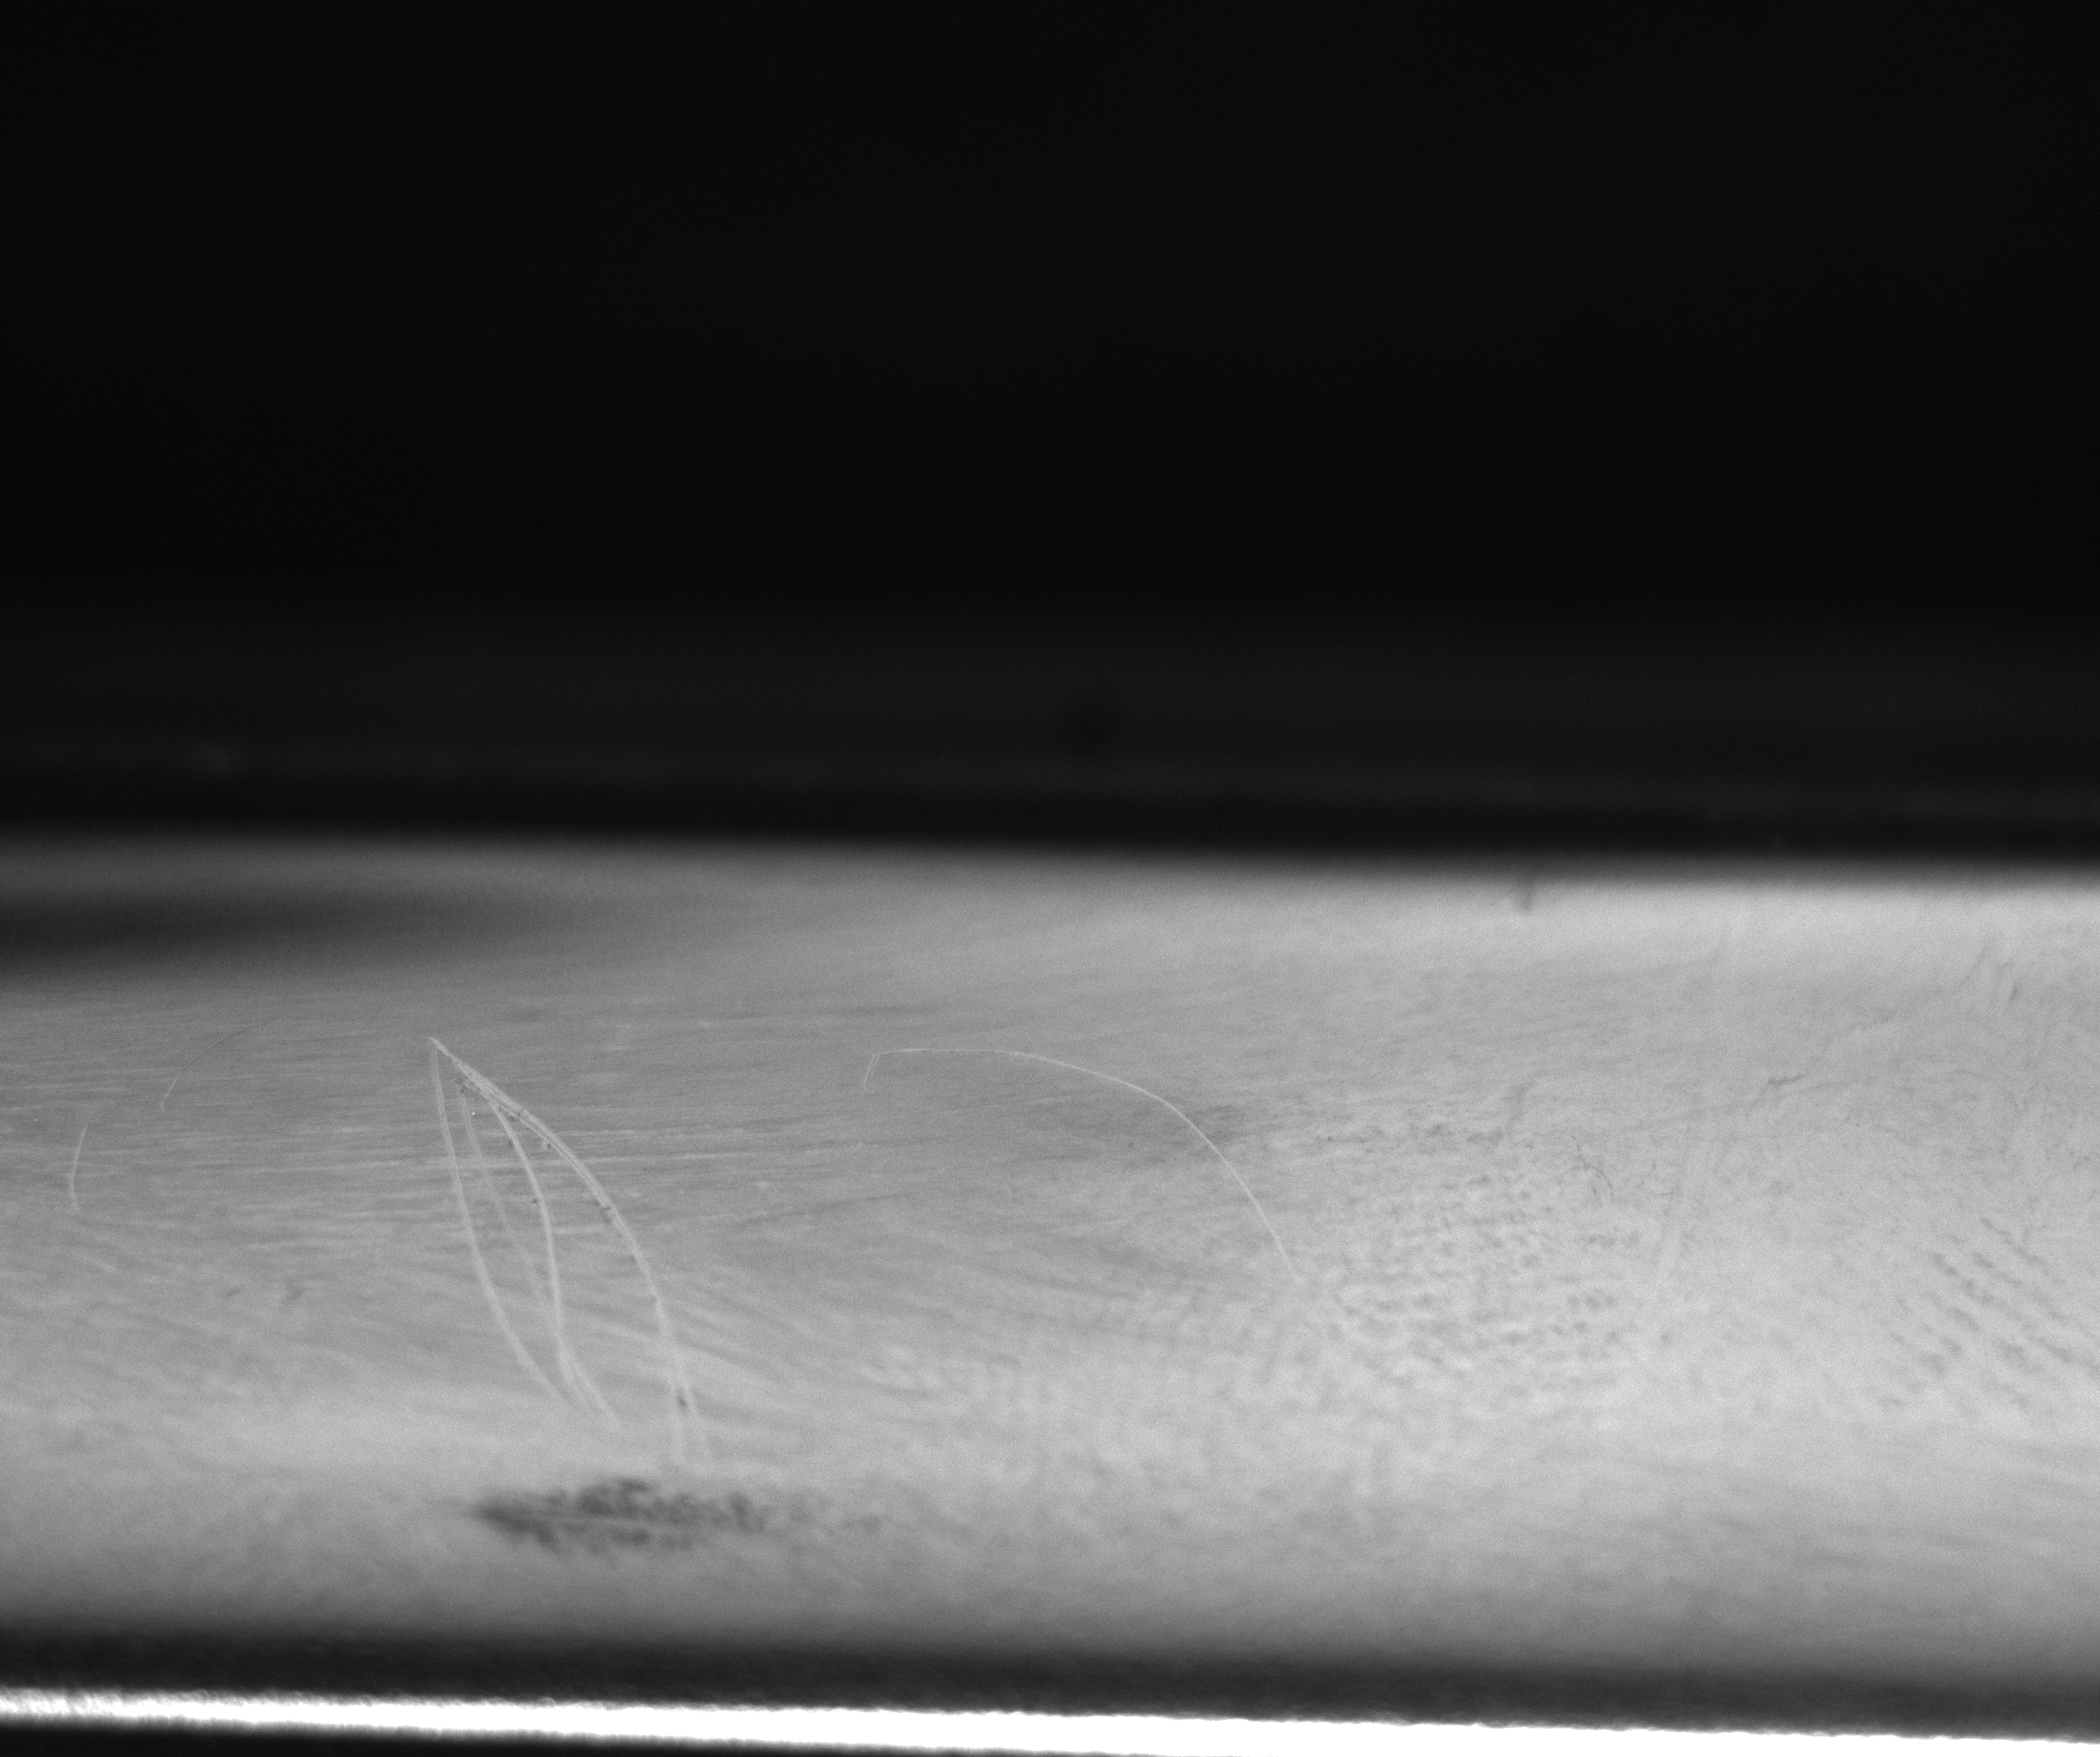

In [29]:
img

In [30]:
test_learn = load_learner(path)

In [31]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category NG

In [32]:
data.classes

['NG', 'OK']

In [35]:
outputs[pred_idx]

tensor(0.9657)